In [57]:
%pip install seaborn

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [59]:
stats = pd.read_csv('vk-odi.csv', index_col=0)
stats['Start Date'] = pd.to_datetime(stats['Start Date'])
stats = stats.sort_values('Start Date')
stats.head()

,Runs,Balls Faced,Fours,Sixes,Strike Rate,Position,Dismissal,Inns,Format,Opposition,Venue,Start Date,Location
1,12,22,1,0,54.54,2,lbw,1,ODI,Sri Lanka,Dambulla,2008-08-18,Away
2,37,67,6,0,55.22,2,caught,2,ODI,Sri Lanka,Dambulla,2008-08-20,Away
3,25,38,4,0,65.78,1,run out,1,ODI,Sri Lanka,Colombo (RPS),2008-08-24,Away
4,54,66,7,0,81.81,1,bowled,1,ODI,Sri Lanka,Colombo (RPS),2008-08-27,Away
5,31,46,3,1,67.39,1,lbw,2,ODI,Sri Lanka,Colombo (RPS),2008-08-29,Away


In [130]:
stats['RA_Runs'] = stats['Runs'].rolling(window=7, min_periods=1, closed='left').mean()
stats['RA_Fours'] = stats['Fours'].rolling(window=7, min_periods=1, closed='left').mean()
stats['RA_Sixes'] = stats['Sixes'].rolling(window=7, min_periods=1, closed='left').mean()
stats['RA_StrikeRate'] = stats['Strike Rate'].rolling(window=7, min_periods=1, closed='left').mean()

#Encoding Categorical Variables
le_opp = LabelEncoder()
stats['ENC_Opposition'] = le_opp.fit_transform(stats['Opposition'])

le_loc = LabelEncoder()
stats['ENC_Location'] = le_loc.fit_transform(stats['Location'])

stats.fillna(0, inplace=True) #ensuring no NaN values

In [131]:
stats.head(15)

,Runs,Balls Faced,Fours,Sixes,Strike Rate,Position,Dismissal,Inns,Format,Opposition,Venue,Start Date,Location,RA_Runs,RA_Fours,RA_Sixes,RA_StrikeRate,ENC_Opposition,ENC_Location
1,12,22,1,0,54.54,2,lbw,1,ODI,Sri Lanka,Dambulla,2008-08-18,Away,0.000000,0.000000,0.000000,0.000000,9,0
2,37,67,6,0,55.22,2,caught,2,ODI,Sri Lanka,Dambulla,2008-08-20,Away,12.000000,1.000000,0.000000,54.540000,9,0
3,25,38,4,0,65.78,1,run out,1,ODI,Sri Lanka,Colombo (RPS),2008-08-24,Away,24.500000,3.500000,0.000000,54.880000,9,0
4,54,66,7,0,81.81,1,bowled,1,ODI,Sri Lanka,Colombo (RPS),2008-08-27,Away,24.666667,3.666667,0.000000,58.513333,9,0
5,31,46,3,1,67.39,1,lbw,2,ODI,Sri Lanka,Colombo (RPS),2008-08-29,Away,32.000000,4.500000,0.000000,64.337500,9,0
6,2,2,0,0,100.00,7,not out,1,ODI,Sri Lanka,Colombo (RPS),2009-09-14,Away,31.800000,4.200000,0.200000,64.948000,9,0
7,16,24,1,0,66.66,4,caught,2,ODI,Pakistan,Centurion,2009-09-26,Away,26.833333,3.500000,0.166667,70.790000,7,0
8,79,104,9,2,75.96,4,not out,2,ODI,West Indies,Johannesburg,2009-09-30,Away,25.285714,3.142857,0.142857,70.200000,11,0
9,30,41,3,0,73.17,4,caught,2,ODI,Australia,Vadodara,2009-10-25,Home,34.857143,4.285714,0.428571,73.260000,1,1
10,10,16,1,0,62.50,3,caught,2,ODI,Australia,Mohali,2009-11-02,Home,33.857143,3.857143,0.428571,75.824286,1,1


In [132]:
#Features
features = ['RA_Runs', 'RA_Fours', 'RA_Sixes', 'RA_StrikeRate', 'ENC_Opposition', 'ENC_Location', 'Position']
predictors = stats[features]
target = stats['Runs']

In [133]:
#splitting data in chronological order, so the model does not predict past data which could happen when using train_test_split
train_size = int(0.8 * len(stats))
x_train = predictors[:train_size]
y_train = target[:train_size]
x_test = predictors[train_size:]
y_test = target[train_size:]

In [134]:
def evaluate_model(model, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(actual, predicted)

    print(f"Model: {model}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

In [135]:
#Finding Optimal Parameters for RandomForestRegressor Model
rfr = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200, 300], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_depth': [6, 8, 10]}
rf_grid = GridSearchCV(estimator=rfr, param_grid=rf_params, cv=5, n_jobs=-1)
rf_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [136]:
print(f"RandomForestRegressor Best Parameters: {rf_grid.best_params_}")

RandomForestRegressor Best Parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [137]:
#Finding Optimal Parameters for XGBoost Regressor Model
best_score = float("inf")
best_params = None

xgb_params = {"max_depth": [3, 5, 7], "learning_rate": [0.01, 0.05, 0.1], "n_estimators": [100, 300, 500], "subsample": [0.8, 0.9, 1.0], "colsample_bytree": [0.8, 0.9, 1.0]}

for md in xgb_params["max_depth"]:
    for lr in xgb_params["learning_rate"]:
        for ne in xgb_params["n_estimators"]:
            for ss in xgb_params["subsample"]:
                for cs in xgb_params["colsample_bytree"]:
                    xgb_model = XGBRegressor(max_depth=md, learning_rate=lr, n_estimators=ne, subsample=ss, colsample_bytree=cs, random_state=42)
                    xgb_model.fit(x_train, y_train)
                    xgb_preds = xgb_model.predict(x_test)
                    rmse = np.sqrt(mean_squared_error(y_test,  xgb_preds))
    
                    if rmse < best_score:
                        best_score = rmse
                        best_params = [md, lr, ne, ss, cs]

print("Best RMSE:", best_score)
print("Best Params:", best_params)

Best RMSE: 41.25633089438744
Best Params: [7, 0.01, 100, 1.0, 0.9]


In [139]:
#Linear Regression Model
pipe = Pipeline([('scale', StandardScaler()), ('model', LinearRegression())])
pipe.fit(x_train, y_train)
lin_ypreds = pipe.predict(x_test)

In [154]:
#RandomForestRegressor Model
rfr = RandomForestRegressor(n_estimators=100, max_depth=6, min_samples_split=10, min_samples_leaf=2, random_state=42)
rfr.fit(x_train, y_train)
rfr_ypreds = rfr.predict(x_test)

In [161]:
#XGBoost Regression Model
xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1, colsample_bytree=0.9, random_state=42)
xgb.fit(x_train, y_train)
xgb_ypreds = xgb.predict(x_test)

In [162]:
#Getting Results and Scores for Models
evaluate_model("Linear Regression", y_test, lin_ypreds)
evaluate_model("RandomForestRegressor", y_test, rfr_ypreds)
evaluate_model("XGBoost Regressor", y_test, xgb_ypreds)

Model: Linear Regression
MAE: 36.99420307772672, MSE: 1873.9858237932851, RMSE: 43.28955790711295, R2: -0.13462368174118566
Model: RandomForestRegressor
MAE: 36.48787730503126, MSE: 1844.8411221823485, RMSE: 42.95161373199322, R2: -0.11697772720663502
Model: XGBoost Regressor
MAE: 35.49144744873047, MSE: 1716.242919921875, RMSE: 41.4275623217427, R2: -0.039116501808166504


Text(0.5, 1.0, 'XGBoost Regression: Predicted vs. Actual Runs')

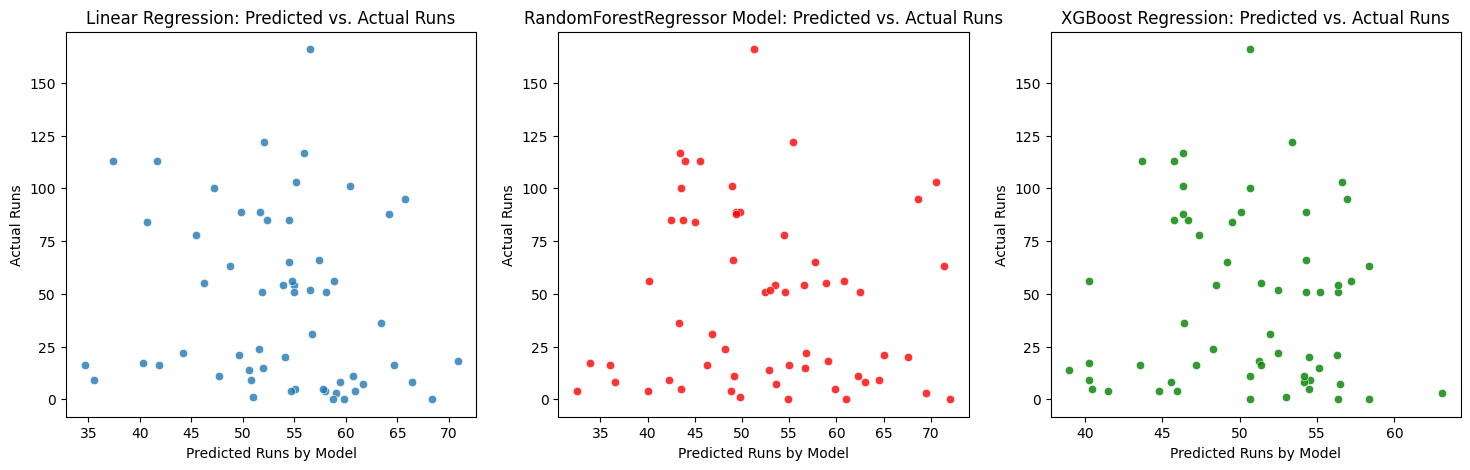

In [163]:
#Visualizations of Predicted vs. Actual
plt.figure(figsize=(18,5))

#Linear Regression
plt.subplot(1,3,1)
sns.scatterplot(x=lin_ypreds, y=y_test, alpha=0.8) 
plt.xlabel("Predicted Runs by Model")
plt.ylabel("Actual Runs")
plt.title("Linear Regression: Predicted vs. Actual Runs")

plt.subplot(1,3,2)
sns.scatterplot(x=rfr_ypreds, y=y_test, alpha=0.8, color="red") 
plt.xlabel("Predicted Runs by Model")
plt.ylabel("Actual Runs")
plt.title("RandomForestRegressor Model: Predicted vs. Actual Runs")

plt.subplot(1,3,3)
sns.scatterplot(x=xgb_ypreds, y=y_test, alpha=0.8, color="green") 
plt.xlabel("Predicted Runs by Model")
plt.ylabel("Actual Runs")
plt.title("XGBoost Regression: Predicted vs. Actual Runs")

Text(0.5, 1.0, 'XGBoost Regression: Feature Importance')

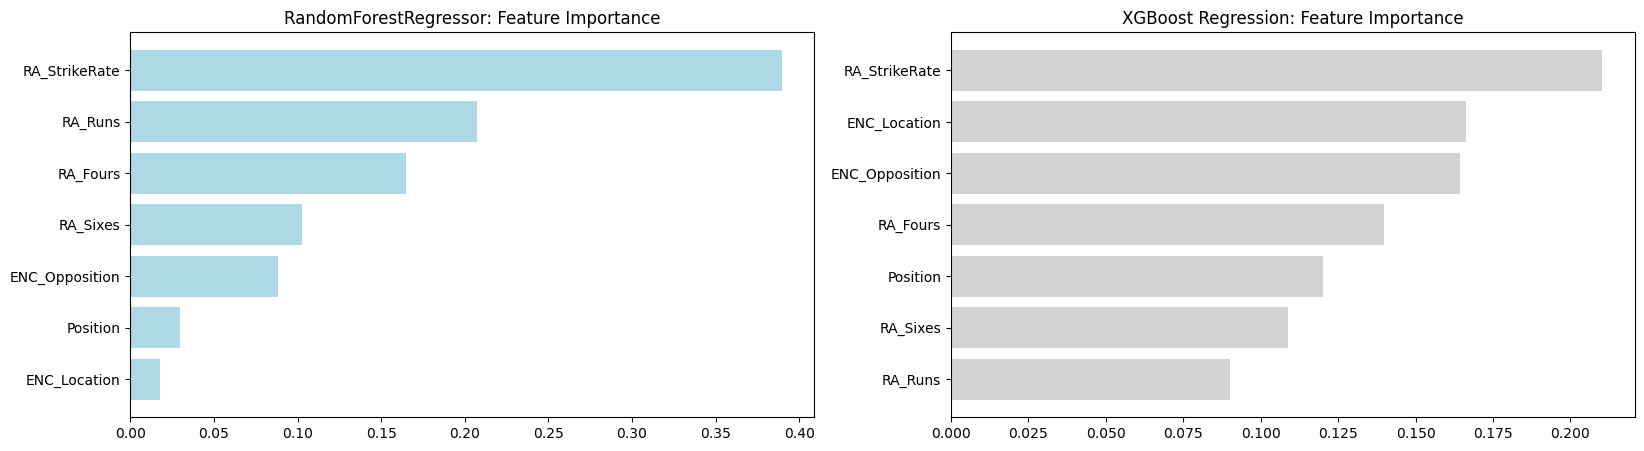

In [164]:
#Feature Importances for RandomForestRegressor and XGBoost
features = ['RA_Runs', 'RA_Fours', 'RA_Sixes', 'RA_StrikeRate', 'ENC_Opposition', 'ENC_Location', 'Position']
plt.figure(figsize=(30,5))

#RandomForestRegressor
rfr_df = pd.DataFrame({'Feature': features, 'Importance': rfr.feature_importances_}).sort_values(by='Importance', ascending=True)
plt.subplot(1,3,1)
plt.barh(rfr_df['Feature'], rfr_df['Importance'], color='lightblue')
plt.title("RandomForestRegressor: Feature Importance")

#XGBoost
xgb_df = pd.DataFrame({'Feature': features, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=True)
plt.subplot(1,3,2)
plt.barh(xgb_df['Feature'], xgb_df['Importance'], color='lightgrey')
plt.title("XGBoost Regression: Feature Importance")